# **BIBLIOTECAS NECESARIAS**

In [1]:
# Bibliotecas para operaciones numéricas y manejo de datos
import numpy as np  # Operaciones numéricas
import pandas as pd  # Manejo de datos en formato tabular

# División del conjunto de datos y validación cruzada
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Modelos de clasificación
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# Técnicas a nivel de datos
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Importar todo el módulo de métricas
import sklearn.metrics

# Métricas de evaluación y reportes
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    roc_curve, auc,
    classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)

# Bibliotecas para gráficos
import matplotlib.pyplot as plt  # Gráficos básicos
import seaborn as sns  # Gráficos estadísticos, con menos código que matplotlib
import plotly.express as px  # Gráficos interactivos con interfaz sencilla y de alto nivel
import plotly.graph_objects as go  # Gráficos interactivos con interfaz más detallada y de bajo nivel
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D  # Para crear la leyenda personalizada

# Herramientas para iteradores
import itertools  # Herramientas funcionales para crear y utilizar iteradores

# Herramientas para preprocesamiento de datos y evaluación de modelos
from sklearn.preprocessing import StandardScaler  # Escalado de características para normalizar datos
from sklearn.model_selection import learning_curve  # Generación de curvas de aprendizaje para evaluar el rendimiento del modelo
from sklearn.model_selection import validation_curve  # Generación de curvas de validación para evaluar el rendimiento del modelo

# **BASE DE DATOS 1**

In [2]:
# Cargar el dataset desde un archivo CSV
trans_fraud = pd.read_csv('C:\\Users\\mmene\\OneDrive\\Escritorio\\RESULTADOS PROYECTO\\DATA\\credit_card_fraud_detection.csv')

**PREPROCESAMIENTO**

In [3]:
# PREPROCESAMIENTO Y ESCALADO DE CARACTERÍSTICAS PARA EL CONJUNTO DE DATOS

# Paso 1: Separar las características (X) de la columna objetivo (y)
X = trans_fraud.drop(['Class'], axis=1)  # Eliminar la columna 'Class' que es la etiqueta objetivo
y = trans_fraud['Class']  # Conservar solo la columna 'Class', que contiene las etiquetas de clase

# Paso 2: Crear un objeto 'StandardScaler' para normalizar las características
scaler = StandardScaler()

# Paso 3: Ajustar el 'scaler' a las características (X) y aplicar la transformación para normalizar
scaled = scaler.fit_transform(X)  # 'fit_transform' ajusta y transforma los datos en un solo paso

# Paso 4: Convertir el array escalado de vuelta a un DataFrame para mantener los nombres de las columnas
X_scaled = pd.DataFrame(scaled, columns=X.columns)

# Paso 5: Unir el DataFrame escalado con la columna 'Class' para reconstruir el conjunto de datos
trans_fraud_scaled = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)  # Se resetea el índice de 'y' para que coincida con 'X_scaled'

# Paso 6: Mostrar las primeras filas del conjunto de datos escalado para verificar la transformación
trans_fraud_scaled.head()  # Muestra las primeras filas del DataFrame escalado

print(trans_fraud_scaled['Class'].value_counts()) # Ver la distribución de clases

Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
# APLICACIÓN DE TÉCNICA DE REMUESTREO (UNDERSAMPLING) PARA BALANCEAR CLASES EN EL CONJUNTO DE DATOS

# Inicializar RandomUnderSampler con una semilla fija para reproducibilidad
rus = RandomUnderSampler(random_state=42)

# Aplicar el remuestreo (undersampling) a las características y la clase
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)

# Crear un DataFrame con los datos remuestreados
trans_fraud_resampled = pd.DataFrame(X_resampled, columns=X.columns)

# Añadir la columna 'Class' con las etiquetas de las clases remuestreadas
trans_fraud_resampled['Class'] = y_resampled

# Mostrar las primeras filas del nuevo DataFrame y la distribución de las clases
print(trans_fraud_resampled.head())  # Visualizar las primeras filas
print(trans_fraud_resampled['Class'].value_counts())  # Ver la distribución de clases

            Time        V1        V2        V3        V4        V5        V6  \
138028 -0.260357  0.671131  0.357682 -0.439632  0.506096  0.218786 -0.844775   
63099  -0.932021 -0.407758  0.717670  0.596568  0.490572  0.158697 -0.239663   
73411  -0.835765 -0.199689 -0.148694  0.740031 -0.924328 -0.463607  0.006514   
164247  0.458181 -0.030787  0.645001 -0.651224 -0.020883  0.127786 -1.012212   
148999 -0.092231  0.943707  0.226102  0.177590  2.730794  0.063802  0.728417   

              V7        V8        V9  ...       V21       V22       V23  \
138028  0.314351 -0.241461 -0.120275  ... -0.231861 -0.592056 -0.226341   
63099   0.400323  0.116606 -0.691965  ...  0.275400  0.797436 -0.147720   
73411  -0.566897 -0.022870 -2.392847  ... -0.181731  0.161779 -0.307062   
164247  0.626990  0.112901 -0.136292  ...  0.484091  1.250612 -0.029553   
148999 -0.583583  0.197583  0.622130  ...  0.140993  0.855661  0.315596   

             V24       V25       V26       V27       V28    Amount  

# ***RANDOM FOREST + RUS***

**CURVAS DE APRENDIZAJE**

In [5]:
start = pd.Timestamp.now()  # Registrar el tiempo de inicio del proceso

# Configuración del modelo Random Forest con hiperparámetros predefinidos
modeloRF = RandomForestClassifier(
    n_jobs=-1,  # Utilizar todos los núcleos disponibles para acelerar el entrenamiento
    random_state=42,  # Semilla para garantizar la reproducibilidad de los resultados
    n_estimators=50,  # Número de árboles en el bosque aleatorio
    criterion="gini",  # Métrica para medir la calidad de las divisiones
    max_features="sqrt",  # Máximo número de características consideradas en cada división
    max_depth=30,  # Profundidad máxima de los árboles
    min_samples_split=2,  # Número mínimo de muestras necesarias para dividir un nodo
    min_samples_leaf=1  # Número mínimo de muestras en una hoja
)

# Definir los porcentajes del conjunto de datos que se usarán para entrenamiento
train_sizes_10 = [0.2, 0.4, 0.6, 0.8, 0.9, 1]  # Porcentajes del conjunto de entrenamiento

# Calcular la curva de aprendizaje
# Esto genera métricas de rendimiento (recall) para distintos tamaños del conjunto de entrenamiento
train_size_abs_10, train_scores_10, test_scores_10 = learning_curve(
    modeloRF,  # Modelo configurado
    X_resampled,  # Conjunto de características escaladas
    y_resampled,  # Etiquetas objetivo
    train_sizes=train_sizes_10,  # Proporciones del conjunto de entrenamiento
    scoring='recall',  # Métrica de evaluación
    cv=10,  # Validación cruzada con 10 particiones
    n_jobs=-1  # Ejecutar en paralelo para mejorar el rendimiento
)

end = pd.Timestamp.now()  # Registrar el tiempo de finalización
print(f"Duración del proceso: {end - start}")  # Imprimir el tiempo total

# Imprimir las métricas obtenidas para cada tamaño del conjunto de entrenamiento
for train_size, cv_train_scores, cv_test_scores in zip(
    train_size_abs_10, train_scores_10, test_scores_10
):
    print(f"{train_size} muestras fueron usadas para entrenar el modelo")  # Tamaño del conjunto de entrenamiento
    print(f"El RECALL promedio en entrenamiento es {cv_train_scores.mean():.2f}")  # Promedio de recall en entrenamiento
    print(f"El RECALL promedio en validación es {cv_test_scores.mean():.2f}")  # Promedio de recall en validación


Duración del proceso: 0 days 00:00:04.811253
177 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es nan
El RECALL promedio en validación es nan
354 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es nan
El RECALL promedio en validación es nan
531 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 1.00
El RECALL promedio en validación es 0.81
708 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 1.00
El RECALL promedio en validación es 0.86
796 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 1.00
El RECALL promedio en validación es 0.88
885 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 1.00
El RECALL promedio en validación es 0.89


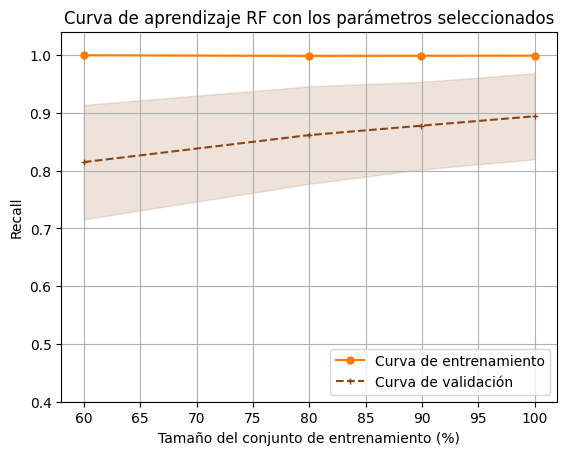

In [6]:
# GRÁFICO LEARNING CURVE

# Convertir los tamaños de entrenamiento a porcentaje del total
total_data_size = max(train_size_abs_10)  # Tamaño total del conjunto de datos
train_size_pct_10 = (train_size_abs_10 / total_data_size) * 100  # Porcentajes de entrenamiento

# Calcular los promedios y desviaciones estándar de recall
train_mean_10 = np.mean(train_scores_10, axis=1)
train_std_10 = np.std(train_scores_10, axis=1)
test_mean_10 = np.mean(test_scores_10, axis=1)
test_std_10 = np.std(test_scores_10, axis=1)

# Graficar la curva de aprendizaje
plt.plot(train_size_pct_10, train_mean_10, color='#FF7B00', marker='o', markersize=5, label='Curva de entrenamiento')
plt.fill_between(train_size_pct_10, train_mean_10 + train_std_10, train_mean_10 - train_std_10, alpha=0.15, color='#FF7B00')

plt.plot(train_size_pct_10, test_mean_10, color='#8B4513', marker='+', markersize=5, linestyle='--', label='Curva de validación')
plt.fill_between(train_size_pct_10, test_mean_10 + test_std_10, test_mean_10 - test_std_10, alpha=0.15, color='#8B4513')

# Personalizar el gráfico
plt.title('Curva de aprendizaje RF con los parámetros seleccionados')  # Título del gráfico
plt.xlabel('Tamaño del conjunto de entrenamiento (%)')  # Etiqueta del eje x
plt.ylabel('Recall')  # Etiqueta del eje y
plt.ylim(0.4, 1.04)  # Límite del eje y
plt.grid()  # Agregar cuadrícula al gráfico
plt.legend(loc='lower right')  # Ubicar la leyenda

# Mostrar el gráfico
plt.show()

**MATRIZ DE CONFUSIÓN**

Matriz de Confusión:
[[96  3]
 [11 87]]


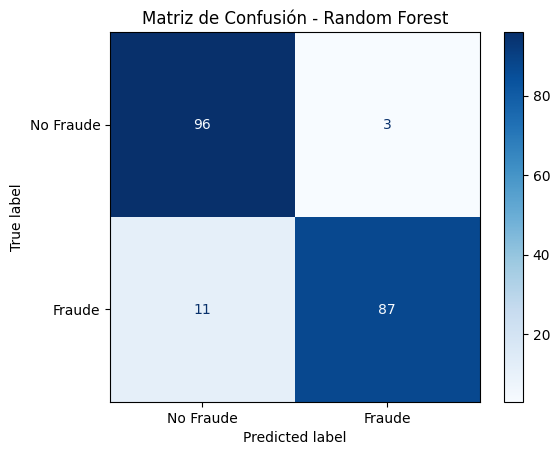


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.90      0.97      0.93        99
      Fraude       0.97      0.89      0.93        98

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

Precisión en entrenamiento: 1.00
Precisión en prueba: 0.93


In [7]:
# Dividir los datos en conjunto de entrenamiento y prueba
# Cambia el parámetro 'test_size' para ajustar el porcentaje del conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42  # 80% entrenamiento, 20% prueba
)

# Configuración del modelo Random Forest
modeloRF = RandomForestClassifier(
    n_jobs=-1,  # Utilizar todos los núcleos disponibles para acelerar el entrenamiento
    random_state=42,  # Semilla para garantizar reproducibilidad
    n_estimators=50,  # Número de árboles en el bosque
    criterion="gini",  # Métrica para medir la calidad de las divisiones
    max_features="sqrt",  # Máximo número de características consideradas en cada división
    max_depth=30,  # Profundidad máxima de los árboles
    min_samples_split=2,  # Número mínimo de muestras necesarias para dividir un nodo
    min_samples_leaf=1  # Número mínimo de muestras en una hoja
)

# Entrenar el modelo con el conjunto de entrenamiento
modeloRF.fit(X_train, y_train)

# Generar predicciones en el conjunto de prueba
y_pred = modeloRF.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

# Visualizar la matriz de confusión
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# Calcular y mostrar métricas adicionales
# Incluye precisión, sensibilidad, especificidad, F1-score, entre otras
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["No Fraude", "Fraude"]))

# Incluir el puntaje general del modelo para referencia
train_score = modeloRF.score(X_train, y_train)  # Precisión en entrenamiento
test_score = modeloRF.score(X_test, y_test)  # Precisión en prueba

print(f"Precisión en entrenamiento: {train_score:.2f}")
print(f"Precisión en prueba: {test_score:.2f}")

# ***XGBoost***

**CURVAS DE APRENDIZAJE**

In [8]:
# Registrar el tiempo de inicio del proceso
start = pd.Timestamp.now()

# Configuración del modelo XGBoost con hiperparámetros predefinidos
xgboost = XGBClassifier(
    n_estimators=20,  # Número de árboles en el modelo
    max_depth=3,  # Profundidad máxima de los árboles
    learning_rate=0.4,  # Tasa de aprendizaje
    gamma=0.25,  # Reducción mínima en pérdida necesaria para dividir un nodo
    reg_lambda=0.25,  # Regularización L2
    reg_alpha=0.25,  # Regularización L1
    booster="gbtree",  # Tipo de booster (árboles de decisión)
    colsample_bytree=1,  # Proporción de características usadas por árbol
    scale_pos_weight=562.601583113457  # Peso para balancear clases desbalanceadas
)

# Definir los porcentajes del conjunto de datos que se usarán para entrenamiento
train_sizes_10 = [0.2, 0.4, 0.6, 0.8, 0.9, 1]  # Porcentajes del conjunto de entrenamiento

# Calcular la curva de aprendizaje
# Esto evalúa el rendimiento (recall) del modelo para distintos tamaños de conjunto de entrenamiento
train_size_abs_10, train_scores_10, test_scores_10 = learning_curve(
    xgboost,  # Modelo configurado
    X_resampled,  # Conjunto de características escaladas
    y_resampled,  # Etiquetas objetivo
    train_sizes=train_sizes_10,  # Porcentajes del conjunto de entrenamiento
    scoring='recall',  # Métrica de evaluación
    cv=10,  # Validación cruzada con 10 particiones
    n_jobs=-1  # Ejecutar en paralelo para mejorar el rendimiento
)

# Registrar el tiempo de finalización del proceso
end = pd.Timestamp.now()
print(f"Duración del proceso: {end - start}")  # Mostrar la duración total del cálculo

# Imprimir las métricas obtenidas para cada tamaño del conjunto de entrenamiento
for train_size, cv_train_scores, cv_test_scores in zip(
    train_size_abs_10, train_scores_10, test_scores_10
):
    print(f"{train_size} muestras fueron usadas para entrenar el modelo")  # Tamaño absoluto del conjunto de entrenamiento
    print(f"El RECALL promedio en entrenamiento es {cv_train_scores.mean():.2f}")  # Promedio de recall en entrenamiento
    print(f"El RECALL promedio en validación es {cv_test_scores.mean():.2f}")  # Promedio de recall en validación

Duración del proceso: 0 days 00:00:00.553642
177 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es nan
El RECALL promedio en validación es nan
354 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es nan
El RECALL promedio en validación es nan
531 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 1.00
El RECALL promedio en validación es 0.64
708 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 1.00
El RECALL promedio en validación es 0.86
796 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 1.00
El RECALL promedio en validación es 0.88
885 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 1.00
El RECALL promedio en validación es 0.94


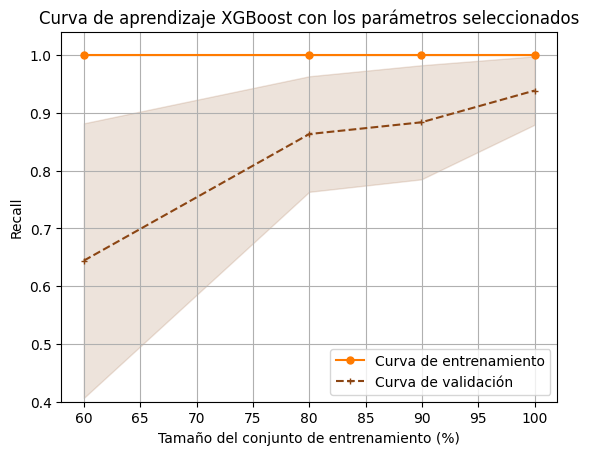

In [9]:
# Calcular los porcentajes del conjunto de entrenamiento
total_data_size = max(train_size_abs_10)  # Tamaño total del conjunto de datos
train_size_pct_10 = (train_size_abs_10 / total_data_size) * 100  # Convertir a porcentajes

# Calcular los promedios y desviaciones estándar de recall
train_mean_10 = np.mean(train_scores_10, axis=1)
train_std_10 = np.std(train_scores_10, axis=1)
test_mean_10 = np.mean(test_scores_10, axis=1)
test_std_10 = np.std(test_scores_10, axis=1)

# Graficar la curva de aprendizaje
plt.plot(train_size_pct_10, train_mean_10, color='#FF7B00', marker='o', markersize=5, label='Curva de entrenamiento')
plt.fill_between(train_size_pct_10, train_mean_10 + train_std_10, train_mean_10 - train_std_10, alpha=0.15, color='#FF7B00')

plt.plot(train_size_pct_10, test_mean_10, color='#8B4513', marker='+', markersize=5, linestyle='--', label='Curva de validación')
plt.fill_between(train_size_pct_10, test_mean_10 + test_std_10, test_mean_10 - test_std_10, alpha=0.15, color='#8B4513')

# Personalización del gráfico
plt.title('Curva de aprendizaje XGBoost con los parámetros seleccionados')  # Título del gráfico
plt.xlabel('Tamaño del conjunto de entrenamiento (%)')  # Etiqueta del eje x
plt.ylabel('Recall')  # Etiqueta del eje y
plt.ylim(0.4, 1.04)  # Límite del eje y
plt.grid()  # Agregar cuadrícula al gráfico
plt.legend(loc='lower right')  # Ubicar la leyenda

# Mostrar el gráfico
plt.show()

**MATRIZ DE CONFUSIÓN**

Matriz de Confusión:
[[77 22]
 [ 5 93]]


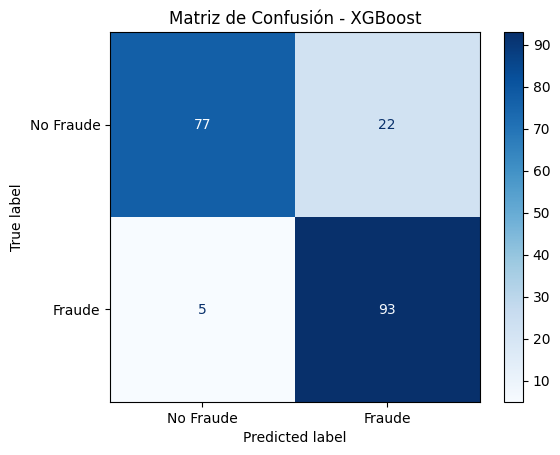


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.94      0.78      0.85        99
      Fraude       0.81      0.95      0.87        98

    accuracy                           0.86       197
   macro avg       0.87      0.86      0.86       197
weighted avg       0.87      0.86      0.86       197

Precisión en entrenamiento: 0.95
Precisión en prueba: 0.86


In [10]:
# Dividir los datos en conjunto de entrenamiento y prueba
# Cambia 'test_size' para ajustar el porcentaje del conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42  # 80% entrenamiento, 20% prueba
)

# Configuración del modelo XGBoost
modeloXGB = XGBClassifier(
    n_estimators=20,  # Número de árboles
    max_depth=3,  # Profundidad máxima de los árboles
    learning_rate=0.4,  # Tasa de aprendizaje
    gamma=0.25,  # Reducción mínima en pérdida necesaria para dividir un nodo
    reg_lambda=0.25,  # Regularización L2
    reg_alpha=0.25,  # Regularización L1
    booster="gbtree",  # Tipo de booster (árboles de decisión)
    colsample_bytree=1,  # Proporción de características usadas por árbol
    scale_pos_weight=562.601583113457,  # Peso para balancear clases desbalanceadas
)

# Entrenar el modelo con el conjunto de entrenamiento
modeloXGB.fit(X_train, y_train)

# Generar predicciones en el conjunto de prueba
y_pred = modeloXGB.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

# Visualizar la matriz de confusión
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

# Calcular y mostrar métricas adicionales
# Incluye precisión, sensibilidad, especificidad, F1-score, entre otras
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["No Fraude", "Fraude"]))

# Incluir el puntaje general del modelo para referencia
train_score = modeloXGB.score(X_train, y_train)  # Precisión en entrenamiento
test_score = modeloXGB.score(X_test, y_test)  # Precisión en prueba

print(f"Precisión en entrenamiento: {train_score:.2f}")
print(f"Precisión en prueba: {test_score:.2f}")

# **BASE DE DATOS 2**

In [11]:
# Cargar el dataset desde un archivo CSV
credit_card = pd.read_csv('C:\\Users\\mmene\\OneDrive\\Escritorio\\RESULTADOS PROYECTO\\DATA\\default_of_credit_card_clients.csv', sep=";")

**PREPROCESAMIENTO**

In [12]:
# PREPROCESAMIENTO Y ESCALADO DE CARACTERÍSTICAS PARA EL CONJUNTO DE DATOS

# Paso 1: Separar las características (X) de la columna objetivo (y)
X_2 = credit_card.drop(['Y'], axis=1)  # Eliminar la columna 'Class' que es la etiqueta objetivo
y_2 = credit_card['Y']  # Conservar solo la columna 'Class', que contiene las etiquetas de clase

# Paso 2: Crear un objeto 'StandardScaler' para normalizar las características
scaler = StandardScaler()

# Paso 3: Ajustar el 'scaler' a las características (X) y aplicar la transformación para normalizar
scaled = scaler.fit_transform(X_2)  # 'fit_transform' ajusta y transforma los datos en un solo paso

# Paso 4: Convertir el array escalado de vuelta a un DataFrame para mantener los nombres de las columnas
X_scaled_2 = pd.DataFrame(scaled, columns=X_2.columns)

# Paso 5: Unir el DataFrame escalado con la columna 'Class' para reconstruir el conjunto de datos
trans_fraud_scaled_2 = pd.concat([X_scaled, y_2.reset_index(drop=True)], axis=1)  # Se resetea el índice de 'y' para que coincida con 'X_scaled'

# Paso 6: Mostrar las primeras filas del conjunto de datos escalado para verificar la transformación
trans_fraud_scaled_2.head()  # Muestra las primeras filas del DataFrame escalado

print(trans_fraud_scaled_2['Y'].value_counts()) # Ver la distribución de clases

Y
0.0    23364
1.0     6636
Name: count, dtype: int64


In [13]:
# APLICACIÓN DE TÉCNICA DE REMUESTREO (UNDERSAMPLING) PARA BALANCEAR CLASES EN EL CONJUNTO DE DATOS

# Inicializar RandomUnderSampler con una semilla fija para reproducibilidad
rus = RandomUnderSampler(random_state=42)

# Aplicar el remuestreo (undersampling) a las características y la clase
X_resampled_2, y_resampled_2 = rus.fit_resample(X_scaled_2, y_2)

# Crear un DataFrame con los datos remuestreados
trans_fraud_resampled = pd.DataFrame(X_resampled_2, columns=X_2.columns)

# Añadir la columna 'Class' con las etiquetas de las clases remuestreadas
trans_fraud_resampled['Class'] = y_resampled_2

# Mostrar las primeras filas del nuevo DataFrame y la distribución de las clases
print(trans_fraud_resampled.head())  # Visualizar las primeras filas
print(trans_fraud_resampled['Class'].value_counts())  # Ver la distribución de clases

             X1        X2        X3        X4        X5        X6        X7  \
7510   1.637943  0.810161  1.451114  0.858557 -0.486615 -0.874991 -0.723570   
15325  0.558907  0.810161  0.185828 -1.057295 -0.052670 -1.764843 -1.558876   
18666 -0.905498  0.810161 -1.079457  0.858557 -1.354506 -0.874991 -0.723570   
7494   1.252573 -1.234323 -1.079457  0.858557 -0.378129  0.014861  0.111736   
1239  -0.674276  0.810161  0.185828 -1.057295 -0.052670 -0.874991 -0.723570   

             X8        X9       X10  ...       X15       X16       X17  \
7510  -0.696663 -0.666599 -0.647565  ... -0.499224 -0.457733 -0.423013   
15325 -1.532192 -1.521944 -1.530046  ... -0.584858 -0.620589 -0.583425   
18666 -1.532192 -1.521944 -1.530046  ... -0.672497 -0.663059 -0.652724   
7494   0.138865  0.188746  0.234917  ...  1.526307  1.189575  1.383139   
1239  -0.696663 -0.666599 -0.647565  ... -0.666342 -0.656545 -0.646075   

            X18       X19       X20       X21       X22       X23  Class  
7510 

# ***RANDOM FOREST***

**CURVAS DE APRENDIZAJE**

In [14]:
# Medir el tiempo de inicio del cálculo
start = pd.Timestamp.now()

# Crear el modelo Random Forest con los parámetros seleccionados
modeloRF = RandomForestClassifier(
    n_jobs=-1,  # Utilizar todos los núcleos disponibles para acelerar el entrenamiento
    random_state=42,  # Semilla para reproducibilidad
    n_estimators=50,  # Número de árboles en el bosque aleatorio
    criterion="gini",  # Métrica para medir la calidad de las divisiones
    max_features="sqrt",  # Número máximo de características consideradas en cada división
    max_depth=30,  # Profundidad máxima de los árboles
    min_samples_split=10,  # Mínimo número de muestras requeridas para dividir un nodo
    min_samples_leaf=1  # Mínimo número de muestras en una hoja
)

# Definir los porcentajes de datos para el conjunto de entrenamiento
train_sizes_10 = [0.2, 0.4, 0.6, 0.8, 0.9, 1]  # Porcentajes del total de datos

# Calcular la curva de aprendizaje
# Esto evalúa el modelo en distintos tamaños de datos de entrenamiento
train_size_abs_10, train_scores_10, test_scores_10 = learning_curve(
    modeloRF,  # Modelo configurado
    X_resampled_2,  # Conjunto de características escaladas
    y_resampled_2,  # Etiquetas objetivo
    train_sizes=train_sizes_10,  # Porcentajes del conjunto de entrenamiento
    scoring='recall',  # Métrica de evaluación
    cv=10,  # Validación cruzada con 10 particiones
    n_jobs=-1  # Ejecutar en paralelo para mejorar el rendimiento
)

# Medir el tiempo de finalización
end = pd.Timestamp.now()
print(f"Duración del proceso: {end - start}")  # Mostrar la duración total

# Mostrar las métricas calculadas para cada tamaño del conjunto de entrenamiento
for train_size, cv_train_scores, cv_test_scores in zip(
    train_size_abs_10, train_scores_10, test_scores_10
):
    print(f"{train_size} muestras fueron usadas para entrenar el modelo")  # Tamaño absoluto del conjunto de entrenamiento
    print(f"El RECALL promedio en entrenamiento es {cv_train_scores.mean():.2f}")  # Promedio de recall en entrenamiento
    print(f"El RECALL promedio en validación es {cv_test_scores.mean():.2f}")  # Promedio de recall en validación

Duración del proceso: 0 days 00:00:06.513458
2388 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es nan
El RECALL promedio en validación es nan
4777 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es nan
El RECALL promedio en validación es nan
7166 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 0.62
El RECALL promedio en validación es 0.25
9555 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 0.87
El RECALL promedio en validación es 0.52
10749 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 0.93
El RECALL promedio en validación es 0.58
11944 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 0.96
El RECALL promedio en validación es 0.64


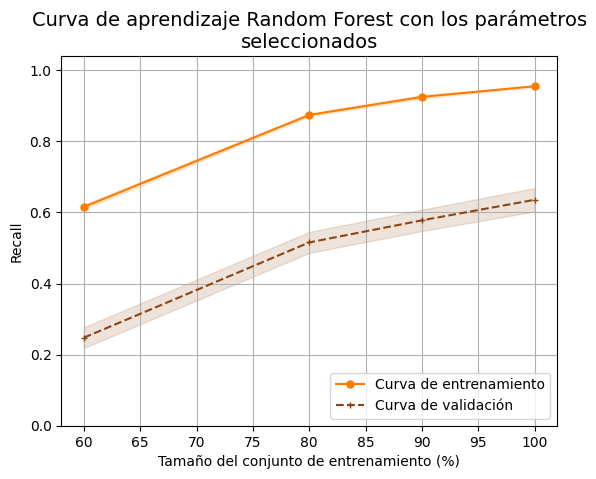

In [15]:
# Calcular el tamaño total del conjunto de datos
total_data_size = max(train_size_abs_10)

# Convertir los tamaños de entrenamiento a porcentajes
train_size_pct_10 = (train_size_abs_10 / total_data_size) * 100

# Calcular los promedios y desviaciones estándar de las métricas
train_mean_10 = np.mean(train_scores_10, axis=1)  # Promedio de recall en entrenamiento
train_std_10 = np.std(train_scores_10, axis=1)  # Desviación estándar en entrenamiento
test_mean_10 = np.mean(test_scores_10, axis=1)  # Promedio de recall en validación
test_std_10 = np.std(test_scores_10, axis=1)  # Desviación estándar en validación

# Graficar la curva de aprendizaje
plt.plot(train_size_pct_10, train_mean_10, color='#FF7B00', marker='o', markersize=5, label='Curva de entrenamiento')
plt.fill_between(train_size_pct_10, train_mean_10 + train_std_10, train_mean_10 - train_std_10, alpha=0.15, color='#FF7B00')

plt.plot(train_size_pct_10, test_mean_10, color='#8B4513', marker='+', markersize=5, linestyle='--', label='Curva de validación')
plt.fill_between(train_size_pct_10, test_mean_10 + test_std_10, test_mean_10 - test_std_10, alpha=0.15, color='#8B4513')

# Personalización del gráfico
plt.title('Curva de aprendizaje Random Forest con los parámetros\nseleccionados', fontsize=14)
plt.xlabel('Tamaño del conjunto de entrenamiento (%)')  # Etiqueta del eje x
plt.ylabel('Recall')  # Etiqueta del eje y
plt.ylim(0, 1.04)  # Límite del eje y
plt.grid()  # Agregar cuadrícula al gráfico
plt.legend(loc='lower right')  # Posición de la leyenda

# Mostrar el gráfico
plt.show()

**MATRIZ DE CONFUSIÓN**

Matriz de Confusión:
[[1033  291]
 [ 526  805]]


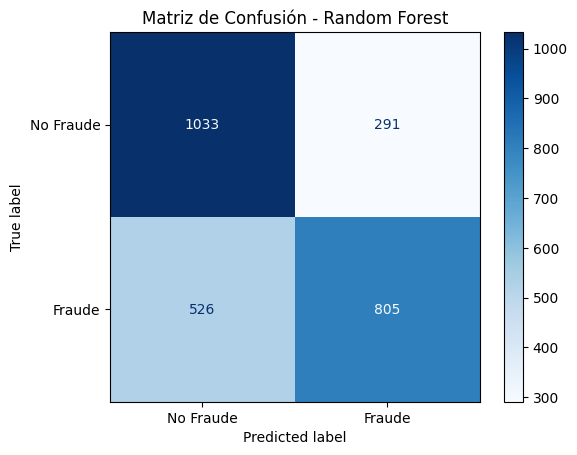


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.66      0.78      0.72      1324
      Fraude       0.73      0.60      0.66      1331

    accuracy                           0.69      2655
   macro avg       0.70      0.69      0.69      2655
weighted avg       0.70      0.69      0.69      2655

Precisión en entrenamiento: 0.95
Precisión en prueba: 0.69


In [16]:
# Dividir los datos en conjunto de entrenamiento y prueba
# Cambia el parámetro 'test_size' para ajustar el porcentaje del conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_2, y_resampled_2, test_size=0.2, random_state=42  # 80% entrenamiento, 20% prueba
)

# Crear el modelo Random Forest con los parámetros seleccionados
modeloRF = RandomForestClassifier(
    n_jobs=-1,  # Utilizar todos los núcleos disponibles para acelerar el entrenamiento
    random_state=42,  # Semilla para reproducibilidad
    n_estimators=50,  # Número de árboles en el bosque aleatorio
    criterion="gini",  # Métrica para medir la calidad de las divisiones
    max_features="sqrt",  # Número máximo de características consideradas en cada división
    max_depth=30,  # Profundidad máxima de los árboles
    min_samples_split=10,  # Mínimo número de muestras requeridas para dividir un nodo
    min_samples_leaf=1  # Mínimo número de muestras en una hoja
)

# Entrenar el modelo con el conjunto de entrenamiento
modeloRF.fit(X_train, y_train)

# Generar predicciones en el conjunto de prueba
y_pred = modeloRF.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

# Visualizar la matriz de confusión
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# Calcular y mostrar métricas adicionales
# Incluye precisión, sensibilidad, especificidad, F1-score, entre otras
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["No Fraude", "Fraude"]))

# Incluir el puntaje general del modelo para referencia
train_score = modeloRF.score(X_train, y_train)  # Precisión en entrenamiento
test_score = modeloRF.score(X_test, y_test)  # Precisión en prueba

print(f"Precisión en entrenamiento: {train_score:.2f}")
print(f"Precisión en prueba: {test_score:.2f}")

# ***XGBoost***

**CURVAS DE APRENDIZAJE**

In [17]:
# Medir tiempo de inicio del cálculo de la curva de aprendizaje
start = pd.Timestamp.now()

# Crear el modelo XGBoost con los parámetros seleccionados
modeloXGB = XGBClassifier(
    n_jobs=-1,  # Utilizar todos los núcleos disponibles para acelerar el entrenamiento
    random_state=42,  # Semilla para garantizar reproducibilidad
    n_estimators=20,  # Número de árboles en el modelo
    max_depth=3,  # Profundidad máxima de los árboles
    learning_rate=0.5,  # Tasa de aprendizaje (step size en cada iteración)
    gamma=0,  # Reducción mínima en la función de pérdida para dividir un nodo
    reg_lambda=0.5,  # Regularización L2 (penalización por sobreajuste)
    reg_alpha=0.25,  # Regularización L1 (penalización por sobreajuste)
    booster="gbtree",  # Tipo de booster (árboles de decisión)
    colsample_bytree=1,  # Proporción de características usadas por cada árbol
    scale_pos_weight=3.5087356753710313  # Peso para manejar clases desbalanceadas
)

# Definir los porcentajes del conjunto de datos que se evaluarán para la curva de aprendizaje
train_sizes_10 = [0.2, 0.4, 0.6, 0.8, 0.9, 1]  # Tamaños relativos del conjunto de entrenamiento

# Calcular la curva de aprendizaje
# Se generan métricas de rendimiento (recall) para distintos tamaños del conjunto de entrenamiento
train_size_abs_10, train_scores_10, test_scores_10 = learning_curve(
    modeloXGB,  # Modelo configurado
    X_resampled_2,  # Conjunto de características escaladas
    y_resampled_2,  # Etiquetas objetivo
    train_sizes=train_sizes_10,  # Porcentajes del conjunto de entrenamiento
    scoring='recall',  # Métrica para evaluar el rendimiento
    cv=10,  # Validación cruzada con 10 particiones
    n_jobs=-1  # Ejecutar en paralelo para mejorar el rendimiento
)

# Medir tiempo de finalización del cálculo
end = pd.Timestamp.now()
print(f"Duración del cálculo de la curva de aprendizaje: {end - start}")

# Mostrar las métricas calculadas para cada tamaño del conjunto de entrenamiento
for train_size, cv_train_scores, cv_test_scores in zip(
    train_size_abs_10, train_scores_10, test_scores_10
):
    print(f"{train_size} muestras fueron usadas para entrenar el modelo")  # Tamaño absoluto del conjunto de entrenamiento
    print(f"El RECALL promedio en entrenamiento es {cv_train_scores.mean():.2f}")  # Promedio de recall en entrenamiento
    print(f"El RECALL promedio en validación es {cv_test_scores.mean():.2f}")  # Promedio de recall en validación

Duración del cálculo de la curva de aprendizaje: 0 days 00:00:00.819917
2388 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es nan
El RECALL promedio en validación es nan
4777 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es nan
El RECALL promedio en validación es nan
7166 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 0.64
El RECALL promedio en validación es 0.55
9555 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 0.88
El RECALL promedio en validación es 0.81
10749 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 0.94
El RECALL promedio en validación es 0.90
11944 muestras fueron usadas para entrenar el modelo
El RECALL promedio en entrenamiento es 0.97
El RECALL promedio en validación es 0.95


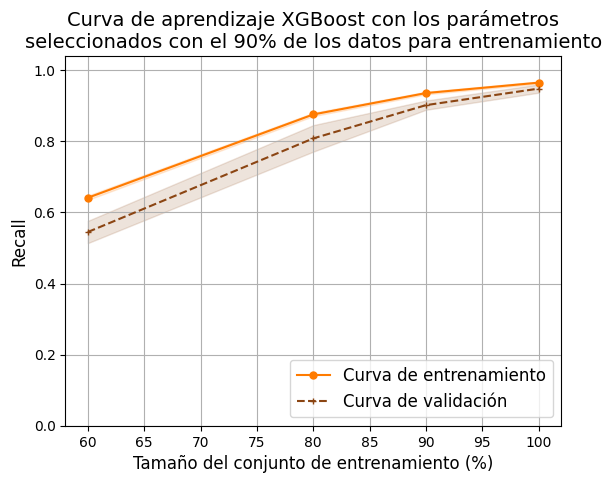

In [18]:
# Calcular el tamaño total del conjunto de datos
total_data_size = max(train_size_abs_10)

# Convertir los tamaños de entrenamiento a porcentajes
train_size_pct_10 = (train_size_abs_10 / total_data_size) * 100

# Calcular los promedios y desviaciones estándar de las métricas
train_mean_10 = np.mean(train_scores_10, axis=1)  # Promedio de recall en entrenamiento
train_std_10 = np.std(train_scores_10, axis=1)  # Desviación estándar en entrenamiento
test_mean_10 = np.mean(test_scores_10, axis=1)  # Promedio de recall en validación
test_std_10 = np.std(test_scores_10, axis=1)  # Desviación estándar en validación

# Graficar la curva de aprendizaje
plt.plot(train_size_pct_10, train_mean_10, color='#FF7B00', marker='o', markersize=5, label='Curva de entrenamiento')
plt.fill_between(train_size_pct_10, train_mean_10 + train_std_10, train_mean_10 - train_std_10, alpha=0.15, color='#FF7B00')

plt.plot(train_size_pct_10, test_mean_10, color='#8B4513', marker='+', markersize=5, linestyle='--', label='Curva de validación')
plt.fill_between(train_size_pct_10, test_mean_10 + test_std_10, test_mean_10 - test_std_10, alpha=0.15, color='#8B4513')

# Personalización del gráfico
plt.title('Curva de aprendizaje XGBoost con los parámetros\nseleccionados con el 90% de los datos para entrenamiento', fontsize=14)
plt.xlabel('Tamaño del conjunto de entrenamiento (%)', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.ylim(0, 1.04)
plt.grid(True)
plt.legend(loc='lower right', fontsize=12)

# Mostrar el gráfico
plt.show()


**MATRIZ DE CONFUSIÓN**

Matriz de Confusión:
[[140 530]
 [ 26 632]]


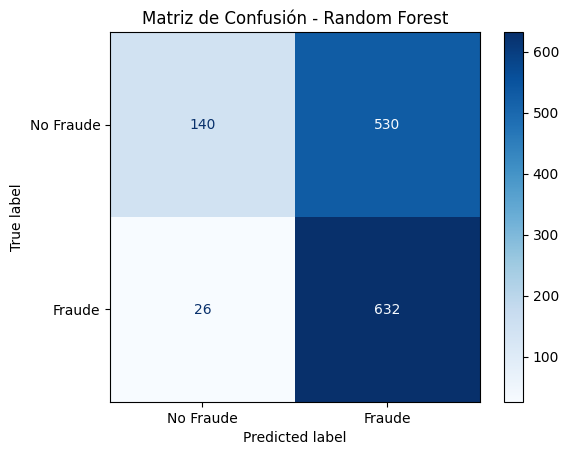


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.84      0.21      0.33       670
      Fraude       0.54      0.96      0.69       658

    accuracy                           0.58      1328
   macro avg       0.69      0.58      0.51      1328
weighted avg       0.69      0.58      0.51      1328

Precisión en entrenamiento: 0.61
Precisión en prueba: 0.58


In [19]:
# Dividir los datos en conjunto de entrenamiento y prueba
# Cambia el parámetro 'test_size' para ajustar el porcentaje del conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_2, y_resampled_2, test_size=0.1, random_state=42  # 90% entrenamiento, 10% prueba
)

# Crear el modelo XGBoost con los parámetros seleccionados
modeloXGB = XGBClassifier(
    n_jobs=-1,  # Utilizar todos los núcleos disponibles para acelerar el entrenamiento
    random_state=42,  # Semilla para garantizar reproducibilidad
    n_estimators=20,  # Número de árboles en el modelo
    max_depth=3,  # Profundidad máxima de los árboles
    learning_rate=0.5,  # Tasa de aprendizaje (step size en cada iteración)
    gamma=0,  # Reducción mínima en la función de pérdida para dividir un nodo
    reg_lambda=0.5,  # Regularización L2 (penalización por sobreajuste)
    reg_alpha=0.25,  # Regularización L1 (penalización por sobreajuste)
    booster="gbtree",  # Tipo de booster (árboles de decisión)
    colsample_bytree=1,  # Proporción de características usadas por cada árbol
    scale_pos_weight=3.5087356753710313  # Peso para manejar clases desbalanceadas
)

# Entrenar el modelo con el conjunto de entrenamiento
modeloXGB.fit(X_train, y_train)

# Generar predicciones en el conjunto de prueba
y_pred = modeloXGB.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

# Visualizar la matriz de confusión
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraude", "Fraude"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# Calcular y mostrar métricas adicionales
# Incluye precisión, sensibilidad, especificidad, F1-score, entre otras
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["No Fraude", "Fraude"]))

# Incluir el puntaje general del modelo para referencia
train_score = modeloXGB.score(X_train, y_train)  # Precisión en entrenamiento
test_score = modeloXGB.score(X_test, y_test)  # Precisión en prueba

print(f"Precisión en entrenamiento: {train_score:.2f}")
print(f"Precisión en prueba: {test_score:.2f}")
